Bước 1: Cài đặt thư viện & Tắt Wandb
Cài đặt thư viện mới nhất để tránh lỗi load_metric.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
save_dir = "/content/drive/MyDrive/My_TrOCR_Project/checkpoints"
# data_dir = "/content/drive/MyDrive/My_TrOCR_Project/data"
# os.chdir(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Bước 2: Chuẩn bị dữ liệu (10 mẫu, chia 70/15/15)

In [ ]:
!rm -rf /content/InkData_word_processed

In [ ]:
!rm -rf /content/vietocr_images

In [ ]:
# 1. Cài đặt thư viện cần thiết
!pip install -q transformers datasets evaluate jiwer torch Pillow scikit-learn matplotlib seaborn accelerate peft

import os
import json
import pandas as pd
from google.colab import drive
import shutil

# =========================================================
# A. KẾT NỐI DRIVE & GIẢI NÉN DỮ LIỆU
# =========================================================
print("--- Đang kết nối Google Drive ---")
drive.mount('/content/drive')

# Đường dẫn file zip trên Drive của bạn
zip_path_drive = "/content/drive/MyDrive/My_TrOCR_Project/data.zip"
zip_path_colab = "/content/data.zip"
extract_path = "/content" # Giải nén ngay tại thư mục gốc

# Kiểm tra xem đã giải nén chưa để không làm lại tốn thời gian
if not os.path.exists("/content/InkData_word_processed"):
    print(f"--- Đang copy {zip_path_drive} sang Colab... ---")
    shutil.copy(zip_path_drive, zip_path_colab)

    print("--- Đang giải nén file zip... (Vui lòng đợi) ---")
    !unzip -q {zip_path_colab} -d {extract_path}
    print("✅ Đã giải nén thành công!")
else:
    print("✅ Đã tìm thấy folder ảnh, bỏ qua bước giải nén.")


--- Đang kết nối Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Đang copy /content/drive/MyDrive/My_TrOCR_Project/data.zip sang Colab... ---
--- Đang giải nén file zip... (Vui lòng đợi) ---
replace /content/vietocr_train_annotation.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/vietocr_valid_annotation.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
✅ Đã giải nén thành công!


In [ ]:
# =========================================================
# B. ĐỌC FILE JSON & SỬA ĐƯỜNG DẪN ẢNH
# =========================================================
print("--- Đang xử lý file split.json ---")

# Giả sử file split.json nằm cùng cấp với InkData_word_processed sau khi giải nén
# Nếu file json của bạn nằm chỗ khác, hãy sửa đường dẫn này:
json_path = "split.json"

if not os.path.exists(json_path):
    # Nếu không thấy ở ngoài, thử tìm trong Drive (nếu bạn để json trên Drive)
    # Ví dụ: json_path = "/content/drive/MyDrive/My_TrOCR_Project/split.json"
    print(f"⚠️ Cảnh báo: Không thấy file {json_path} tại /content. Hãy đảm bảo bạn đã upload file json.")
else:
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Chuyển thành DataFrame
    train_df = pd.DataFrame(data['train'])
    val_df = pd.DataFrame(data['val'])
    test_df = pd.DataFrame(data['test'])

    # --- HÀM FIX ĐƯỜNG DẪN ---
    # Ảnh sau giải nén nằm tại: /content/InkData_word_processed
    img_root_dir = "/content"

    def fix_path(path):
        # path cũ: InkData_word_processed\filename.png (hoặc /kaggle/...)
        clean_path = path.replace('\\', '/')
        filename = os.path.basename(clean_path)
        return os.path.join(img_root_dir, "InkData_word_processed", filename)

    # Áp dụng
    train_df['image_path'] = train_df['image_path'].apply(fix_path)
    val_df['image_path'] = val_df['image_path'].apply(fix_path)
    test_df['image_path'] = test_df['image_path'].apply(fix_path)

    # KIỂM TRA LẠI LẦN CUỐI
    sample_img = train_df['image_path'].iloc[0]
    if os.path.exists(sample_img):
        print(f"✅ KIỂM TRA ẢNH: OK! Đã tìm thấy: {sample_img}")
        print(f"Số lượng mẫu: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    else:
        print(f"❌ LỖI: Vẫn không tìm thấy ảnh tại {sample_img}")
        print("Hãy kiểm tra lại tên folder sau khi giải nén!")

--- Đang xử lý file split.json ---
✅ KIỂM TRA ẢNH: OK! Đã tìm thấy: /content/InkData_word_processed/20160122_0078_25463_tg_2_2_23.png
Số lượng mẫu: Train=15817, Val=3389, Test=3390


Bước 3: Xây dựng Dataset & Metrics

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import TrOCRProcessor
import evaluate

# ==========================================================
# 4. KHỞI TẠO DATASET
# ==========================================================
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

class IAMDataset(Dataset):
    def __init__(self, df, processor, max_target_length=128):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_path'][idx]
        text = self.df['text'][idx]
        try:
            image = Image.open(file_name).convert("RGB")
        except Exception as e:
            # print(f"Lỗi ảnh: {file_name}") # Bật lên nếu muốn debug
            image = Image.new('RGB', (384, 384), color='white')

        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        labels = [l if l != self.processor.tokenizer.pad_token_id else -100 for l in labels]

        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}

# Tạo Dataset
train_dataset = IAMDataset(train_df, processor)
eval_dataset = IAMDataset(val_df, processor)
test_dataset = IAMDataset(test_df, processor)

# Hàm tính CER và Accuracy
import evaluate
import numpy as np

# Tải các metrics
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Giải mã output
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    # 1. CER (Character Error Rate)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    # 2. WER (Word Error Rate)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    # 3. Word Accuracy (Exact Match Accuracy)
    # Tính tỷ lệ số dòng dự đoán đúng hoàn toàn so với thực tế
    correct_count = sum([1 for p, l in zip(pred_str, label_str) if p == l])
    word_accuracy = correct_count / len(pred_str) if len(pred_str) > 0 else 0

    return {
        "cer": cer,
        "wer": wer,
        "word_accuracy": word_accuracy
    }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Bước 4: Cấu hình Train & Lưu Checkpoint

In [ ]:
from transformers import (
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator,
)
from peft import LoraConfig, get_peft_model, TaskType
import torch
import warnings

warnings.filterwarnings("ignore")

# =========================================================
# 1. LOAD MODEL GỐC
# =========================================================
print("Đang tải model...")
model = VisionEncoderDecoderModel.from_pretrained(
    "microsoft/trocr-base-handwritten"
)

# =========================================================
# 2. CẤU HÌNH MODEL (ĐÚNG CHUẨN TrOCR)
# =========================================================
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.sep_token_id

# vocab_size CHỈ GÁN CHO DECODER (KHÔNG gán cho model.config)
model.decoder.config.vocab_size = len(processor.tokenizer)

# Cấu hình generate
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

# =========================================================
# 3. CẤU HÌNH & ÁP DỤNG LoRA (FIX target_modules)
# =========================================================
lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=["query", "key", "value"],  # FIX
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)

model = get_peft_model(model, lora_config)

print("=== THAM SỐ SẼ TRAIN (LoRA) ===")
model.print_trainable_parameters()

# =========================================================
# 4. CẤU HÌNH TRAINING
# =========================================================
import os
save_dir = "/content/drive/MyDrive/My_TrOCR_Project/checkpoints"
os.makedirs(save_dir, exist_ok=True)
training_args = Seq2SeqTrainingArguments(
    output_dir=save_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-4,
    num_train_epochs=10,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",

    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="word_accuracy",
    greater_is_better=True,

    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    label_names=["labels"],
)

# =========================================================
# 5. KHỞI TẠO TRAINER
# =========================================================
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.tokenizer,   # ĐÚNG cho TrOCR
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
)

# =========================================================
# 6. CHECK TRƯỚC KHI TRAIN (KHUYẾN NGHỊ)
# =========================================================
print("decoder vocab size:", model.decoder.config.vocab_size)
print("tokenizer vocab size:", len(processor.tokenizer))

# =========================================================
# 7. TRAIN
# =========================================================
print("Bắt đầu huấn luyện...")
# train_result = trainer.train()
checkpoint_path = "/content/drive/MyDrive/My_TrOCR_Project/checkpoints/checkpoint-3956"

print(f"Đang khôi phục huấn luyện từ: {checkpoint_path}")

# Lệnh này sẽ load toàn bộ trạng thái cũ và chạy tiếp epoch dở dang
trainer.train(resume_from_checkpoint=checkpoint_path)


Đang tải model...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== THAM SỐ SẼ TRAIN (LoRA) ===
trainable params: 3,538,944 || all params: 337,460,736 || trainable%: 1.0487


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.


decoder vocab size: 50265
tokenizer vocab size: 50265
Bắt đầu huấn luyện...
Đang khôi phục huấn luyện từ: /content/drive/MyDrive/My_TrOCR_Project/checkpoints/checkpoint-3956


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Cer,Wer,Word Accuracy
3,1.508100,1.516830,0.684490,0.912659,0.088817
4,1.290100,1.346009,0.600343,0.910593,0.091177
5,1.117800,1.182616,0.557069,0.889348,0.112127
6,0.991900,1.103439,0.536761,0.887873,0.114193
7,0.887900,1.006315,0.532562,0.889643,0.110652
8,0.803100,0.971893,0.530249,0.889643,0.112423
9,0.742000,0.915839,0.533333,0.889348,0.110947
10,0.688600,0.882035,0.525278,0.881971,0.118914


TrainOutput(global_step=19780, training_loss=0.8029546755027964, metrics={'train_runtime': 10417.4367, 'train_samples_per_second': 15.183, 'train_steps_per_second': 1.899, 'total_flos': 1.1984197425498685e+20, 'train_loss': 0.8029546755027964, 'epoch': 10.0})

Bước 5: Vẽ biểu đồ Loss (Yêu cầu nhận xét)

In [ ]:
import matplotlib.pyplot as plt

# Trích xuất lịch sử training
history = trainer.state.log_history

train_loss = []
val_loss = []
val_cer = []
val_wer = []
val_acc = []
epochs = []

# Lọc dữ liệu
for entry in history:
    # Lấy metric Validation (thường nằm ở các step đánh giá)
    if 'eval_loss' in entry:
        val_loss.append(entry['eval_loss'])
        val_cer.append(entry['eval_cer'])
        val_wer.append(entry['eval_wer'])
        val_acc.append(entry['eval_word_accuracy'])
        epochs.append(entry['epoch'])

    # Lấy metric Train (thường Hugging Face chỉ log Train Loss theo epoch)
    elif 'loss' in entry:
        train_loss.append(entry['loss'])

# Đảm bảo độ dài khớp nhau để vẽ (lấy min length)
min_len = min(len(train_loss), len(val_loss))

# Vẽ 4 biểu đồ
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 1. Loss (Train vs Val)
axs[0, 0].plot(train_loss[:min_len], label='Train Loss', marker='o')
axs[0, 0].plot(val_loss[:min_len], label='Val Loss', marker='x')
axs[0, 0].set_title('Loss (Hàm mất mát)')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. Word Accuracy (Validation)
axs[0, 1].plot(val_acc[:min_len], label='Val Word Accuracy', color='green', marker='o')
axs[0, 1].set_title('Word Accuracy (Độ chính xác từ)')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].grid(True)

# 3. WER (Validation)
axs[1, 0].plot(val_wer[:min_len], label='Val WER', color='red', marker='o')
axs[1, 0].set_title('WER (Tỷ lệ lỗi từ - Càng thấp càng tốt)')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].grid(True)

# 4. CER (Validation)
axs[1, 1].plot(val_cer[:min_len], label='Val CER', color='orange', marker='o')
axs[1, 1].set_title('CER (Tỷ lệ lỗi ký tự - Càng thấp càng tốt)')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

Đang đánh giá trên tập Test...



=== KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ===
1. Word Accuracy (Độ chính xác từ): 11.39%
2. WER (Word Error Rate)          : 0.8870
3. CER (Character Error Rate)     : 0.5359

=== CHI TIẾT DỰ ĐOÁN ===
Gốc: 'tháp'  ---  Dự đoán: 'Tháá'
Gốc: 'vĩnh'  ---  Dự đoán: 'v��h'
Gốc: 'chát'  ---  Dự đoán: 'chi'
Gốc: 'từ'  ---  Dự đoán: 't���'
Gốc: 'hơn'  ---  Dự đoán: 'h��n'
Gốc: 'P'  ---  Dự đoán: '���'
Gốc: 'trưa'  ---  Dự đoán: 'tr��a'
Gốc: 'lãng'  ---  Dự đoán: 'l�ng'
Gốc: 'Gần'  ---  Dự đoán: 'G��n'
Gốc: 'Câu'  ---  Dự đoán: 'Câu'
Gốc: 'hảo'  ---  Dự đoán: 'h��'
Gốc: 'Rịa'  ---  Dự đoán: 'R��'
Gốc: 'chốn'  ---  Dự đoán: 'ch��n'
Gốc: 'trao'  ---  Dự đoán: 'trâ'
Gốc: 'nó'  ---  Dự đoán: 'nó'
Gốc: 'đưa'  ---  Dự đoán: 'đ�a'
Gốc: 'lao'  ---  Dự đoán: 'la'
Gốc: 'danh'  ---  Dự đoán: 'dan'
Gốc: 'to'  ---  Dự đoán: 'to'
Gốc: 'nồng'  ---  Dự đoán: 'n��ng'
Gốc: 'thung'  ---  Dự đoán: 'thu'
Gốc: 'sơ'  ---  Dự đoán: 'S��'
Gốc: 'núi'  ---  Dự đoán: 'núú'
Gốc: 'tròn'  ---  Dự đoán: 'trààn'
Gốc: 'trùm'  ---  Dự

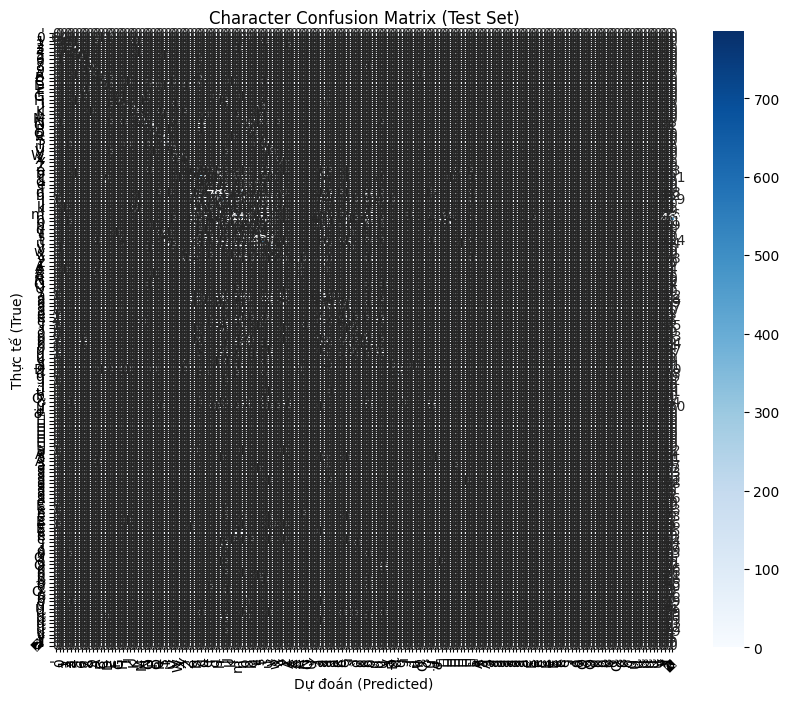

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print("Đang đánh giá trên tập Test...")
predict_output = trainer.predict(test_dataset)

# 1. Hiển thị các chỉ số định lượng
metrics = predict_output.metrics
print("\n=== KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ===")
print(f"1. Word Accuracy (Độ chính xác từ): {metrics['test_word_accuracy']:.2%}")
print(f"2. WER (Word Error Rate)          : {metrics['test_wer']:.4f}")
print(f"3. CER (Character Error Rate)     : {metrics['test_cer']:.4f}")

# 2. Confusion Matrix (Cấp ký tự)
predictions = predict_output.predictions
labels = predict_output.label_ids

pred_str = processor.batch_decode(predictions, skip_special_tokens=True)
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.batch_decode(labels, skip_special_tokens=True)

print("\n=== CHI TIẾT DỰ ĐOÁN ===")
y_true_chars = []
y_pred_chars = []

for ref, pred in zip(label_str, pred_str):
    print(f"Gốc: '{ref}'  ---  Dự đoán: '{pred}'")

    # Chuẩn bị dữ liệu vẽ Confusion Matrix
    min_len = min(len(ref), len(pred))
    y_true_chars.extend(list(ref[:min_len]))
    y_pred_chars.extend(list(pred[:min_len]))

if len(y_true_chars) > 0:
    unique_chars = sorted(list(set(y_true_chars + y_pred_chars)))
    cm = confusion_matrix(y_true_chars, y_pred_chars, labels=unique_chars)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_chars, yticklabels=unique_chars, cmap='Blues')
    plt.title('Character Confusion Matrix (Test Set)')
    plt.ylabel('Thực tế (True)')
    plt.xlabel('Dự đoán (Predicted)')
    plt.show()

In [ ]:
import evaluate
import pandas as pd
import numpy as np
from tabulate import tabulate # Để in bảng đẹp

# 1. Khởi tạo Metrics
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

print("⏳ Đang chạy dự đoán trên tập Test (Vui lòng đợi)...")
# Hàm predict sẽ tự động dùng GPU và batch_size đã cài đặt
output = trainer.predict(test_dataset)

# 2. Giải mã (Decode) kết quả từ ID sang Chữ
pred_ids = output.predictions
label_ids = output.label_ids

# Thay thế giá trị -100 trong nhãn (do collation tạo ra) về pad_token_id để decode không lỗi
label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

# Decode hàng loạt
pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

# 3. Tính toán các chỉ số
# CER (Lỗi cấp ký tự)
cer = cer_metric.compute(predictions=pred_str, references=label_str)

# WER (Lỗi cấp từ)
wer = wer_metric.compute(predictions=pred_str, references=label_str)

# Word Accuracy (Độ chính xác tuyệt đối: Đúng y hệt mới tính)
# Strip() để loại bỏ khoảng trắng thừa đầu đuôi nếu có
correct_count = sum([1 for p, l in zip(pred_str, label_str) if p.strip() == l.strip()])
word_accuracy = correct_count / len(pred_str)

# 4. In Bảng Kết Quả Tổng Hợp
print("\n" + "="*40)
print("📊 BẢNG KẾT QUẢ ĐÁNH GIÁ TẬP TEST")
print("="*40)
print(f"✅ Word Accuracy (Độ chính xác) : {word_accuracy:.2%} (Càng cao càng tốt)")
print(f"❌ WER (Tỷ lệ lỗi từ)           : {wer:.4f}   (Càng thấp càng tốt)")
print(f"❌ CER (Tỷ lệ lỗi ký tự)        : {cer:.4f}   (Càng thấp càng tốt)")
print("="*40)

⏳ Đang chạy dự đoán trên tập Test (Vui lòng đợi)...



📊 BẢNG KẾT QUẢ ĐÁNH GIÁ TẬP TEST
✅ Word Accuracy (Độ chính xác) : 11.39% (Càng cao càng tốt)
❌ WER (Tỷ lệ lỗi từ)           : 0.8870   (Càng thấp càng tốt)
❌ CER (Tỷ lệ lỗi ký tự)        : 0.5359   (Càng thấp càng tốt)
